# Analysis of Popular Description Words using Goodreads Data

blah blah blah

### Content

Topics that are covered in this tutorial are:
- Loading data from Goodreads API
- Processing descriptions into meaningful words
- Most common words used in general
- Most common words used, grouped by popularity of the book
- Most common words used, grouped by rating of the book
- Most common words used overtime
- Most common words used in reviews, grouped by rating of the book

In [79]:
import time, json
import requests
import csv
from bs4 import BeautifulSoup
import nltk
import string
import pandas as pd
from collections import Counter

### Loading data from Goodreads API

In [2]:
def read_api_key(filepath):
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')
    
api_key = read_api_key('api_key.txt')
print(api_key)

yfmkhh2aWg8dnQyvnoRXg


Test function for querying goodreads API

In [5]:
def goodreads_query(api_key):
    """
    api_key (string): API key
    url (string): Base query URL
    query (dictionary): Query parameters
    """
    request_params = {'id':68428, 'key':api_key, 'format':'xml', 'text_only':'true'}
    response = requests.get('https://www.goodreads.com/book/show', params=request_params)
    soup = BeautifulSoup(response.text, 'lxml')
    shelves = soup.find('popular_shelves')
    return response

temp_response = goodreads_query(api_key)

Get metadata about a book given its book ID. 

Metadata includes: book_id, author, publication_date(month/day/year), publisher, review_count, rating_count, average_rating and genre and description

In [6]:
# Get metadata about a book given its book ID
def get_book_metadata(api_key, book_id):
    request_params = {'id':book_id, 'key':api_key, 'format':'xml', 'text_only':'true'}
    response = requests.get('https://www.goodreads.com/book/show', params=request_params)
    
    book_info = {}
    book_info['book_id'] = book_id
    soup = BeautifulSoup(response.text, 'lxml')
    
    # Author
    book_info['author'] = soup.find('author').find('name').text
    
    # Publication date
    year = soup.find('publication_year').text
    month = soup.find('publication_month').text
    day = soup.find('publication_day').text
    book_info['publication_date'] = str(month) + '/' + str(day) + '/' + str(year)
    
    # Publisher
    book_info['publisher'] = soup.find('publisher').text
    
    # Review information
    book_info['review_count'] = soup.find('text_reviews_count').text
    
    # Rating information
    book_info['rating_count'] = soup.find('ratings_count').text
    book_info['average_rating'] = soup.find('average_rating').text
    
    # Treat the genre as the most popular shelf this book has been placed on
    book_info['genre'] = soup.find('popular_shelves').find('shelf')['name']
    
    return book_info

We downloaded 23 csv files of 10k books each, totaling in 230k books.

In [ ]:
# Save all book metadata as a CSV
def download_book_metadata(api_key):
    data_columns = ['book_id', 'author', 'publication_date', 'publisher', 'review_count', 'rating_count', 'average_rating', 'genre']
    
    with open('metadata.csv', 'w', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, data_columns, lineterminator='\n')
        dict_writer.writeheader()
        
        # TODO: iterate through book IDs - add a time.sleep(1) between each iteration
        current_metadata = get_book_metadata(api_key, 68428)
        dict_writer.writerow(current_metadata)

download_book_metadata(api_key)

Get all the reviews for a given book ID as a list of dictionaries.

Review data includes: book_id, rating, date (day-month-year), and text

In [129]:
def get_reviews(api_key, book_id):
    request_params = {'id':book_id, 'key':api_key, 'format':'xml', 'text_only':'true'}
    response = requests.get('https://www.goodreads.com/book/show', params=request_params)
    
    soup = BeautifulSoup(response.text, 'lxml')
    iframe = soup.find('reviews_widget').find('iframe')
    
    all_reviews = []
    
    reviews_url = iframe['src']
    response_reviews = requests.get(reviews_url)
    
    while(1):
        review_soup = BeautifulSoup(response_reviews.text, 'lxml')
        reviews = review_soup.find_all('div', {'class':'gr_review_container'})

        for review in reviews:
            current_review = {}

            # Extract the rating
            rating = review.find('span', {'class':'gr_rating'})
            if (rating):
                rating = rating.find_all(text=True)
                rating_num = 0
                for i in range(len(rating[0])):
                    if (ord(rating[0][i]) == 9733):
                        rating_num += 1
            else:
                rating_num = -1

            # Extract the date
            date = review.find('span', {'class':'gr_review_date'}).find_all(text=True)
            date = [x.strip() for x in date][0]

            # Extract the review text
            s = [x.strip() for x in review.find('div', {'class':'gr_review_text'}).find_all(text=True)]
            s = [x for x in s if x]

            # Ignore the last element, the '...more'
            review_text = ' '.join(s[:-1])

            # Remove the last word, since it will be partial
            review_text = ' '.join(review_text.split(' ')[:-1])

            current_review['book_id'] = book_id
            current_review['rating'] = rating_num
            current_review['date'] = date
            current_review['text'] = review_text

            all_reviews.append(current_review)

        # See if there is another page of reviews
        if (review_soup.find_all('a', {'class':'next_page'}) != []):
            # There is another page
            reviews_url = 'https://goodreads.com' + review_soup.find('a', {'class':'next_page'})['href']
            response_reviews = requests.get(reviews_url)
        else:
            # No more pages of reviews
            break
        
    return all_reviews

We downloaded 5 csv files of 10k reviews each, totaling in 60k books.

In [130]:
def download_reviews(api_key):
    data_columns = ['book_id', 'rating', 'date', 'text']
    
    with open('reviews.csv', 'w', encoding='utf-8') as output_file:
        dict_writer = csv.DictWriter(output_file, data_columns, lineterminator='\n')
        dict_writer.writeheader()
        
        # TODO: iterate through book IDs - add a time.sleep(1) between each iteration
        current_reviews = get_reviews(api_key, 68428)
        dict_writer.writerows(current_reviews)

book_reviews = get_reviews(api_key, 68428)

### Processing descriptions into meaningful words

In [84]:
def csv_to_df(path):
    df = pd.read_csv(path)
    df = df[pd.notnull(df['description'])]
    return df

In [69]:
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')

We take out the words book and author, since it occurs the most times in most categories, yet it seemes meaningless.

In [109]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    text = text.lower()
    text = text.replace("'s", "")
    text = text.replace("'", "")
    for char in text: 
        if (char in string.punctuation): text = text.replace(char, " ")
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word, 'v') for word in words]
    filtered_words = [word for word in words if word not in stopwords \
                      and word != 'book' and word != 'autho' and word != "'" and word != '"']
    return filtered_words

def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    for i, row in df.iterrows():
        original = row['description']
        df.at[i, 'description'] = process(original)
    return df

We will load 23 files of metadata and process them.

In [131]:
df_full = []
for x in range(1,24):
    df = csv_to_df('metadata/metadata%d.csv'%(x))
    processed = process_all(df)
    df_full.append(processed)

### Most common words used in general

In [133]:
def popular_words(processed):
    fin = []
    for i, row in processed.iterrows():
        fin.extend(row['description'])
    count = Counter(fin)
    return count

In [135]:
counter_all = Counter()
for i in range(0,23):
    processed = df_full[i]
    rare = popular_words(processed)
    counter_all += rare

Few significant words seems to be: life, world, time, love, and man

In [205]:
print(counter_all.most_common(100))

[('new', 28374), ('one', 26810), ('’', 26503), ('life', 25351), ('world', 21541), ('work', 21396), ('time', 20101), ('de', 20039), ('make', 17499), ('first', 16459), ('write', 15994), ('include', 15836), ('find', 14821), ('love', 14225), ('story', 13549), ('live', 13330), ('history', 12020), ('take', 11893), ('also', 11822), ('author', 11520), ('know', 11472), ('la', 11447), ('man', 10722), ('years', 10634), ('american', 10288), ('war', 10128), ('use', 10042), ('well', 10005), ('come', 9920), ('two', 9907), ('become', 9519), ('people', 9393), ('read', 8766), ('many', 8709), ('help', 8498), ('family', 8464), ('like', 8359), ('even', 8238), ('provide', 8237), ('way', 8225), ('edition', 8134), ('best', 8089), ('us', 7877), ('novel', 7870), ('offer', 7870), ('get', 7771), ('•', 7722), ('show', 7702), ('go', 7670), ('great', 7644), ('readers', 7468), ('begin', 7442), ('young', 7333), ('”', 7224), ('give', 7192), ('learn', 7190), ('study', 7088), ('bring', 7072), ('“', 7017), ('women', 7017)

### Most common words used, grouped by popularity of the book

In [17]:
import matplotlib.pyplot as plt 
%matplotlib inline

We decided that rating count is a good way to determine the popularity of the book. By visualizing the distribution of the rating count, we decide on the bin for popularity to be: 0 to 100k, 100k to 200k,  200k to 300k,  300k to 400k, 400k to 500k,  500k to 600k, 600k to 700k, 700k to 800k, 800k to 900k, 900k to 1000k, 1000k to 3000k and 3000kabove 

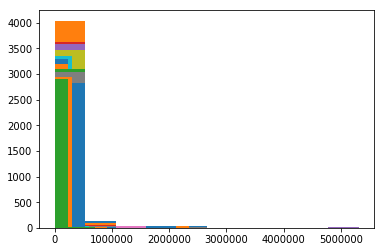

In [137]:
for x in range(1,24):
    df = csv_to_df('metadata/metadata%d.csv'%(x))
    plt.hist(df['rating_count'])

In [201]:
def popular_words_rc(processed):
    R0_50k, R50k_100k, R100k_200k,  R200k_300k,  R300k_400k, R400k_500k,  R500k_600k, R600k_700k, \
    R700k_800k, R800k_900k, R900k_1000k, R1000k_3000k, R3000kabove \
                = [], [], [], [], [], [], [], [], [], [], [], [], []
    for i, row in processed.iterrows():
        if (0 <= row['rating_count'] < 50000): R0_50k.extend(row['description'])
        elif (50000 <= row['rating_count'] < 100000): R50k_100k.extend(row['description'])
        elif (100000 <= row['rating_count'] < 200000): R100k_200k.extend(row['description'])
        elif (200000 <= row['rating_count'] < 300000): R200k_300k.extend(row['description'])
        elif (300000 <= row['rating_count'] < 400000): R300k_400k.extend(row['description'])
        elif (400000 <= row['rating_count'] < 500000): R400k_500k.extend(row['description'])
        elif (500000 <= row['rating_count'] < 600000): R500k_600k.extend(row['description'])
        elif (600000 <= row['rating_count'] < 700000): R600k_700k.extend(row['description'])
        elif (700000 <= row['rating_count'] < 800000): R700k_800k.extend(row['description'])
        elif (800000 <= row['rating_count'] < 900000): R800k_900k.extend(row['description'])
        elif (900000 <= row['rating_count'] < 1000000): R900k_1000k.extend(row['description'])
        elif (1000000 <= row['rating_count'] < 3000000): R1000k_3000k.extend(row['description'])
        elif (3000000 <= row['rating_count']): R3000kabove.extend(row['description'])
            
    return Counter(R0_50k), Counter(R50k_100k), Counter(R100k_200k), Counter(R200k_300k), Counter(R300k_400k), \
            Counter(R400k_500k), Counter(R500k_600k), Counter(R600k_700k), Counter(R700k_800k), \
            Counter(R800k_900k), Counter(R900k_1000k), Counter(R1000k_3000k), Counter(R3000kabove)

In [202]:
R0_50k, R50k_100k, R100k_200k,  R200k_300k,  R300k_400k, R400k_500k,  R500k_600k, R600k_700k, \
    R700k_800k, R800k_900k, R900k_1000k, R1000k_3000k, R3000kabove \
        = Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(),\
            Counter(), Counter(), Counter(), Counter()
for x in range(0,23):
    processed = df_full[x]
    a, b, c, d, e, f, g, h, i, j, k, l, m = popular_words_rc(processed)
    R0_50k += a
    R50k_100k += b
    R100k_200k += c
    R200k_300k += d
    R300k_400k += e
    R400k_500k += f
    R500k_600k += g
    R600k_700k += h
    R700k_800k += i
    R800k_900k += j
    R900k_1000k += k
    R1000k_3000k += l
    R3000kabove += m

You can see that books that were extremely popular included words like harry (Harry Potter), gatsby (The Great Gatsby), and kill (To Kill a Mockingbird)

In [203]:
print("0 to 50k:   " + str(R0_50k.most_common(10)) + "\n")
print("50k to 100k:   " + str(R50k_100k.most_common(10)) + "\n")
print("100k to 200k:   " + str(R100k_200k.most_common(10))+ "\n")
print("200k to 300k:   " + str(R200k_300k.most_common(10))+ "\n")
print("300k to 400k:   " + str(R300k_400k.most_common(10))+ "\n")
print("400k to 500k:   " + str(R400k_500k.most_common(10))+ "\n")
print("500k to 600k:   " + str(R500k_600k.most_common(10))+ "\n")
print("600k to 700k:   " + str(R600k_700k.most_common(10))+ "\n")
print("700k to 800k:   " + str(R700k_800k.most_common(10))+ "\n")
print("800k to 900k:   " + str(R800k_900k.most_common(10))+ "\n")
print("900k to 1000k:   " + str(R900k_1000k.most_common(10))+ "\n")
print("1000k to 3000k:   " + str(R1000k_3000k.most_common(10))+ "\n")
print("3000k above:   " + str(R3000kabove.most_common(10))+ "\n")

0 to 50k:   [('new', 26581), ('’', 24289), ('one', 24184), ('life', 23387), ('work', 19953), ('world', 19581), ('time', 18438), ('de', 16946), ('make', 16301), ('include', 14965)]

50k to 100k:   [('’', 849), ('one', 841), ('de', 775), ('life', 736), ('new', 618), ('world', 609), ('time', 601), ('work', 532), ('first', 521), ('make', 501)]

100k to 200k:   [('de', 989), ('’', 642), ('one', 636), ('new', 529), ('la', 515), ('life', 470), ('world', 469), ('time', 453), ('love', 451), ('first', 444)]

200k to 300k:   [('de', 326), ('one', 288), ('la', 187), ('’', 183), ('story', 178), ('world', 176), ('new', 160), ('love', 159), ('time', 152), ('war', 152)]

300k to 400k:   [('de', 170), ('’', 127), ('world', 121), ('—', 108), ('first', 104), ('story', 103), ('one', 99), ('la', 90), ('life', 86), ('live', 80)]

400k to 500k:   [('ring', 197), ('one', 167), ('de', 162), ('edition', 118), ('lord', 103), ('que', 95), ('write', 87), ('story', 85), ('become', 84), ('fantasy', 82)]

500k to 600

### Most common words used, grouped by rating of the book

By visualizing the distribution of the rating count, we decide on the bin for popularity to be: 0 to 1, 1 to 2, 2 to 2.5, 2.5 to 3, 3 to 3.3, 3.3 to 3.6, 3.6 to 3.9, 3.9 to 4.2, 4.2 to 4.5 and 4.5 to 5.0

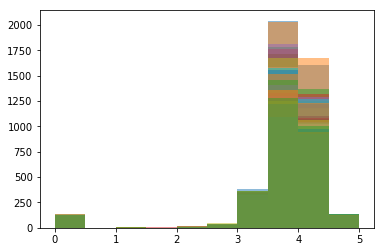

In [142]:
for x in range(1,24):
    df = csv_to_df('metadata/metadata%d.csv'%(x))
    plt.hist(df['average_rating'], alpha=0.5)

In [143]:
def popular_words_rating(processed):
    zero, one, two, two2, three1, three2, three3, four1, four2 = \
    [], [], [], [], [], [], [], [], []
    for i, row in processed.iterrows():
        if (0 <= round(row['average_rating'], 1) < 1.0): zero.extend(row['description'])
        elif (1 <= round(row['average_rating'], 1) < 2.0): one.extend(row['description'])
        elif (2.0 <= round(row['average_rating'], 1) < 2.5): two.extend(row['description'])
        elif (2.5 <= round(row['average_rating'], 1) < 3.0): two2.extend(row['description'])
        elif (3.0 <= round(row['average_rating'], 1) < 3.3): three1.extend(row['description'])
        elif (3.3 <= round(row['average_rating'], 1) < 3.6): three2.extend(row['description'])
        elif (3.6 <= round(row['average_rating'], 1) < 3.9): three3.extend(row['description'])
        elif (4.2 <= round(row['average_rating'], 1) < 4.5): four1.extend(row['description'])
        elif (4.5 <= round(row['average_rating'], 1) < 5.0): four2.extend(row['description'])
    return Counter(zero), Counter(one), Counter(two), Counter(two2), Counter(three1), \
            Counter(three2), Counter(three3), Counter(four1), Counter(four2)

In [145]:
zero, one, two, two2, three1, three2, three3, four1, four2 = \
    Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter()
for x in range(0,23):
    processed = df_full[x]
    a, b, c, d, e, f, g, h, i= popular_words_rating(processed)
    zero += a
    one += b
    two += c
    two2 += d
    three1 += e
    three2 += f
    three3 += g
    four1 += h
    four2 += i

In [146]:
print("rating 0.0 to 1.0 :   " + str(zero.most_common(20)) + "\n")
print("rating 1.0 to 2.0 :   " + str(one.most_common(10)) + "\n")
print("rating 2.0 to 2.5 :   " + str(two.most_common(10)) +"\n")
print("rating 2.5 to 3.0 :   " + str(two2.most_common(20)) + "\n")
print("rating 3.0 to 3.3:   " + str(three1.most_common(20)) + "\n")
print("rating 3.3 to 3.6 :   " + str(three2.most_common(20)) + "\n")
print("rating 3.6 to 3.9:   " + str(three3.most_common(20)) + "\n")
print("rating 4.2 to 4.5 :   " + str(four1.most_common(20)) + "\n")
print("rating 4.5 to 5.0 :   " + str(four2.most_common(20)) + "\n")

rating 0.0 to 1.0 :   [('work', 894), ('include', 705), ('new', 679), ('study', 586), ('use', 525), ('provide', 500), ('also', 476), ('write', 467), ('de', 458), ('make', 425), ('one', 424), ('first', 412), ('life', 403), ('world', 387), ('present', 378), ('author', 377), ('volume', 371), ('well', 346), ('time', 345), ('state', 317)]

rating 1.0 to 2.0 :   [('use', 45), ('include', 31), ('work', 29), ('new', 24), ('write', 22), ('students', 22), ('find', 20), ('also', 20), ('provide', 20), ('author', 20)]

rating 2.0 to 2.5 :   [('new', 101), ('work', 94), ('include', 76), ('one', 69), ('write', 68), ('study', 65), ('life', 61), ('use', 56), ('make', 55), ('de', 55)]

rating 2.5 to 3.0 :   [('new', 247), ('’', 235), ('life', 234), ('one', 217), ('make', 195), ('work', 191), ('include', 172), ('world', 170), ('time', 165), ('use', 132), ('author', 128), ('live', 128), ('write', 127), ('love', 125), ('first', 124), ('find', 119), ('de', 118), ('also', 115), ('take', 114), ('get', 111)]



### Most common words used overtime

We will load deta frames again and this time, get rid of all books with no publication data and ignore month and date of publication

In [153]:
df_time = []
for x in range(1,24):
    df = csv_to_df('metadata/metadata%d.csv'%(x))
    df = df[df.publication_date != '//']
    df["publication_date"] = df["publication_date"].apply(lambda x: x[-4:])
    processed = process_all(df)
    df_time.append(processed)

In [189]:
def popular_words_time(processed):
    t1900, t1950, t1960, t1970, t1980, t1990, t1995, t2000, t2002, t2005, t2007, t2010, t2012, t2015, t2020 = \
    [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    
    for i, row in processed.iterrows():
        if (0 < int(row['publication_date']) <= 1900): t1900.extend(row['description'])
        elif (1900 < int(row['publication_date']) <= 1950): t1950.extend(row['description'])
        elif (1950 < int(row['publication_date']) <= 1960): t1960.extend(row['description'])
        elif (1960 < int(row['publication_date']) <= 1970): t1970.extend(row['description'])
        elif (1970 < int(row['publication_date']) <= 1980): t1980.extend(row['description'])
        elif (1980 < int(row['publication_date']) <= 1990): t1990.extend(row['description'])
        elif (1990 < int(row['publication_date']) <= 1995): t1995.extend(row['description'])
        elif (1995 < int(row['publication_date']) <= 2000): t2000.extend(row['description'])
        elif (2000 < int(row['publication_date']) <= 2002): t2002.extend(row['description'])
        elif (2002 < int(row['publication_date']) <= 2005): t2005.extend(row['description'])
        elif (2005 < int(row['publication_date']) <= 2007): t2007.extend(row['description'])
        elif (2007 < int(row['publication_date']) <= 2010): t2010.extend(row['description'])
        elif (2010 < int(row['publication_date']) <= 2012): t2012.extend(row['description'])
        elif (2012 < int(row['publication_date']) <= 2015): t2015.extend(row['description'])
        elif (2015 < int(row['publication_date']) <= 2020): t2020.extend(row['description'])
        
    return Counter(t1900), Counter(t1950), Counter(t1960), Counter(t1970), Counter(t1980), \
        Counter(t1990), Counter(t1995), Counter(t2000), Counter(t2002), Counter(t2005), Counter(t2007), \
        Counter(t2010), Counter(t2012), Counter(t2015), Counter(t2020)

In [190]:
t1900,t1950, t1960, t1970, t1980, t1990, t1995, t2000, t2002, t2005, t2007, t2010, t2012, t2015, t2020 \
        = Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), \
            Counter(), Counter(), Counter(), Counter() , Counter(), Counter(), Counter()
for x in range(0, 23):
    processed = df_time[x]
    b, c, d, e, f, g, h, i, j, k, l, m, n, o, p = popular_words_time(processed)
    t1900 +=b 
    t1950 +=c
    t1960 += d
    t1970 += e
    t1980 += f 
    t1990 += g
    t1995 += h
    t2000 += i 
    t2002 += j
    t2005 += k 
    t2007 += l
    t2010 += m
    t2012 += n
    t2015 += o
    t2020 += p

It is interesting to see specific names like Kurt Vonnegut appear very commonly in 1960-1970. Also, one thing to notice is the popularity of the word, 'war' starting in 1980 and becoming increasingly popular.

In [191]:
# print("1800 and below :   " + str(t1800.most_common(30)) + "\n")
print("1800-1900 :   " + str(t1900.most_common(30)) + "\n")
print("1900-1950 :   " + str(t1950.most_common(30)) + "\n")
print("1950-1960 :   " + str(t1960.most_common(30)) + "\n")
print("1960-1970 :   " + str(t1970.most_common(30)) + "\n")
print("1970-1980 :   " + str(t1980.most_common(30)) + "\n")
print("1980-1990 :   " + str(t1990.most_common(30)) + "\n")
print("1990-1995 :   " + str(t1995.most_common(30)) + "\n")
print("1995-2000 :   " + str(t2000.most_common(30)) + "\n")
print("2000-2002 :   " + str(t2002.most_common(30)) + "\n")
print("2002 - 2005 :   " + str(t2005.most_common(30)) + "\n")
print("2005 - 2007 :   " + str(t2007.most_common(30)) + "\n")
print("2005 - 2010 :   " + str(t2010.most_common(30)) + "\n")
print("2010 - 2012 :   " + str(t2012.most_common(30)) + "\n")
print("2012 - 2015 :   " + str(t2015.most_common(30)) + "\n")
print("2015 - 2020 :   " + str(t2020.most_common(30)) + "\n")

1800-1900 :   [('می', 18), ('و', 18), ('به', 14), ('را', 13), ('که', 12), ('در', 10), ('او', 9), ('پوریا', 8), ('برای', 8), ('از', 8), ('home', 7), ('bible', 6), ('soseki', 6), ('با', 6), ('feng', 6), ('shui', 6), ('use', 5), ('well', 5), ('make', 5), ('work', 5), ('art', 5), ('نام', 5), ('ی', 5), ('سرزمین', 5), ('اما', 5), ('قصه', 5), ('form', 4), ('also', 4), ('time', 4), ('follow', 4)]

1900-1950 :   [('work', 69), ('edition', 55), ('first', 53), ('life', 48), ('one', 47), ('de', 47), ('story', 45), ('write', 38), ('new', 34), ('library', 30), ('make', 29), ('history', 28), ('part', 28), ('loeb', 27), ('volumes', 27), ('la', 27), ('roman', 26), ('years', 26), ('publish', 25), ('great', 25), ('cover', 25), ('classical', 24), ('man', 24), ('novel', 23), ('also', 22), ('three', 20), ('ce', 20), ('world', 20), ('know', 20), ('’', 20)]

1950-1960 :   [('one', 74), ('’', 65), ('work', 64), ('life', 58), ('write', 55), ('story', 54), ('world', 49), ('new', 48), ('·', 48), ('man', 43), ('lo

#  DONT FORGET: we should look at some words like war and american, history, woman, and visualize the proportion of its use by time interval.

In [192]:
time_periods = [t1900, t1950, t1960, t1970, t1980, t1990, t2000, t2002, t2005, t2007, t2010, t2012, t2015, t2020]
labels = ['<1900', '<1950', '<1960', '<1970', '<1980', '<1990', '<2000', '<2002', '<2005', '<2007', '<2010', \
          '<2012', '<2015', '<2020']
def visualize_word(labels, bins, word):
    word_dict = {}
    for i in range(len(bins)):
        counter = bins[i]
        label = labels[i]
        word_dict[label] = counter[word] / (sum(counter.values())) * 100
        
    plt.bar(list(word_dict.keys()), word_dict.values(), color='g')
    plt.xticks(rotation=90)
    plt.title(word)
    plt.show()

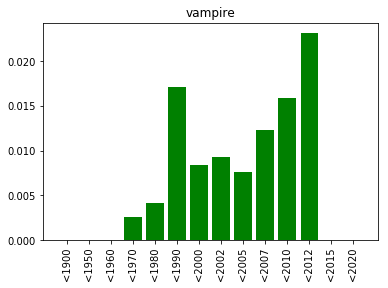

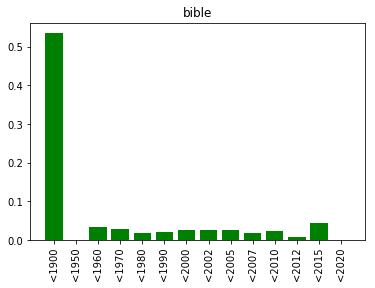

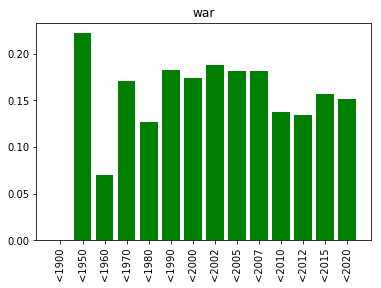

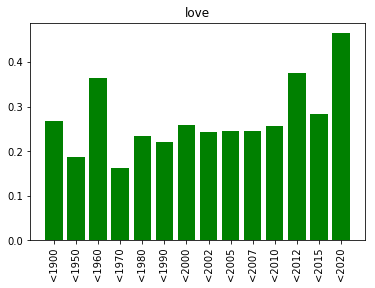

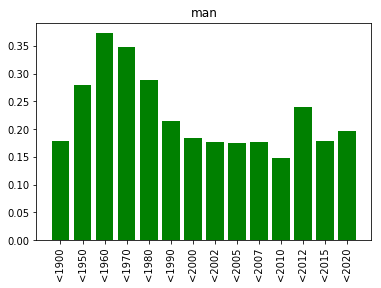

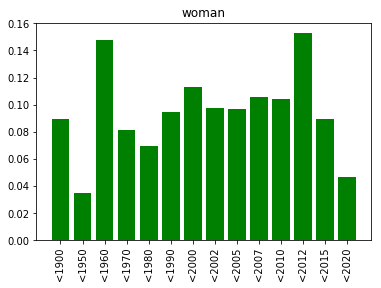

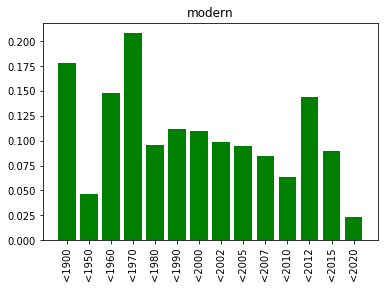

In [206]:
visualize_word(labels, time_periods, 'vampire')
visualize_word(labels, time_periods, 'bible')
visualize_word(labels, time_periods, 'war')
visualize_word(labels, time_periods, 'love')
visualize_word(labels, time_periods, 'man')
visualize_word(labels, time_periods, 'woman')
visualize_word(labels, time_periods, 'modern')

### Most common words used in REVIEWS, grouped by rating of the book

For the purpose of using the same processing functions, review columns were renamed to "description".

In [122]:
def review_csv_to_df(path):
    df = pd.read_csv(path)
    df = df[pd.notnull(df['text'])]
    df = df.rename(index=str, columns={"text": "description"})
    return df

In [123]:
def popular_words_review(processed):
    one, two, three, four, five = [], [], [], [], []
    for i, row in processed.iterrows():
        if (row['rating'] == 1.0): one.extend(row['description'])
        elif (row['rating'] == 2.0): two.extend(row['description'])
        elif (row['rating'] == 3.0): three.extend(row['description'])
        elif (row['rating'] == 4.0): four.extend(row['description'])
        elif (row['rating'] == 5.0): five.extend(row['description'])
    return Counter(one), Counter(two), Counter(three), Counter(four), Counter(five)

In [126]:
one, two, three, four, five = Counter(), Counter(), Counter(), Counter(), Counter()
dfs = []
for i in range(1,6):
    df = review_csv_to_df('reviewdata/reviews%d.csv'%(i))
    dfs.append(df)
    processed = process_all(df)
    a, b, c, d, e = popular_words_review(processed)
    one += a
    two += b
    three += c
    four += d
    five += e

As expected, words such as 'love', 'really', 'great' and 'like' were used more commonly in books with higher rating.

In [128]:
print("rating one :   " + str(one.most_common(30)) + "\n")
print("rating two :   " + str(two.most_common(30)) + "\n")
print("rating three :   " + str(three.most_common(30)) + "\n")
print("rating four :   " + str(four.most_common(30)) + "\n")
print("rating five :   " + str(five.most_common(30)) + "\n")

rating one :   [('read', 24630), ('like', 12602), ('one', 10800), ('write', 9341), ('get', 9304), ('think', 7871), ('character', 7138), ('really', 6982), ('time', 6247), ('make', 6153), ('first', 6050), ('story', 5698), ('would', 5434), ('go', 5359), ('im', 5226), ('dont', 5120), ('page', 5112), ('didnt', 4942), ('find', 4936), ('finish', 4931), ('give', 4853), ('know', 4826), ('love', 4777), ('say', 4577), ('author', 4569), ('much', 4562), ('good', 4418), ('’', 4395), ('even', 4254), ('want', 3993)]

rating two :   [('read', 39910), ('like', 24164), ('one', 19153), ('write', 14744), ('really', 14697), ('get', 14617), ('story', 14188), ('think', 13755), ('character', 13158), ('time', 11526), ('first', 11383), ('much', 11182), ('interest', 10467), ('good', 10077), ('find', 10060), ('didnt', 9818), ('make', 9306), ('’', 9187), ('would', 9089), ('go', 8986), ('love', 8981), ('im', 8658), ('know', 8075), ('say', 7647), ('author', 7389), ('well', 7034), ('dont', 6973), ('give', 6946), ('end